# Pan-Tompkins QRS Complex Detection

The first step in a lot of ECG processing is finding QRS complexes. The Pan-Tompkins algorithm is a series of pre-processing steps and a detection algorithm for finding these complexes. We'll can see it in action below.

## Imports

In [12]:
!pip install mpld3

     |████████████████████████████████| 1.0 MB 14.9 MB/s 
  Created wheel for mpld3: filename=mpld3-0.5.5-py3-none-any.whl size=200907 sha256=4b1f38a1214a846073df4365da618747bcdd8a4e492cd8ff7e4c3381bfbfe104
  Stored in directory: /root/.cache/pip/wheels/3b/f3/08/a11447ac4ea31d7603142e76b4cba9e48b2fa7d82b76b69731
Successfully built mpld3


In [13]:
import glob
import os

from matplotlib import pyplot as plt
import mpld3
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import scipy.signal

np.warnings.filterwarnings('ignore')

In [14]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
#!nvidia-smi

In [ ]:
#!pip install mpld3

In [5]:
# You will need to mount your drive using the following commands:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/ipython_notebooks/ecg-processing/walkthroughs/QRS-complex-detection/

/content/drive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/ipython_notebooks/ecg-processing/walkthroughs/QRS-complex-detection


We will be using the ECGs in these files as examples

In [7]:
fs = 300
f0 = 'A00010.npz'
f1 = 'A01593.npz'

A simple version of the algorithm

In [8]:
def BandpassFilter(signal, fs=300):
    """Bandpass filter the signal between 5 and 15 Hz."""
    b, a = sp.signal.butter(3, (5, 15), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def MovingSum(signal, fs=300):
    """Moving sum operation with window size of 150ms."""
    n_samples = int(round(fs * 0.150))
    return pd.Series(signal).rolling(n_samples, center=True).sum().values

def FindPeaks(signal, order=10):
    """A simple peak detection algorithm."""
    msk = (signal[order:-order] > signal[:-order * 2]) & (signal[order:-order] > signal[order * 2:])
    for o in range(1, order):
        msk &= (signal[order:-order] > signal[o: -order * 2 + o])
        msk &= (signal[order:-order] > signal[order * 2 - o: -o])
    return msk.nonzero()[0] + order

def ThresholdPeaks(filtered_signal, pks):
    """Threshold detected peaks to select the QRS complexes."""
    thresh = np.mean(filtered_signal[pks])
    return pks[filtered_signal[pks] > thresh]

def LocalizeMaxima(signal, pks, fs):
    """Find R-wave peaks in the original, unfiltered signal.
    
    This function is mostly for aesthetic purposes and not part of the algorithm.
    We only do it here because we know that the R-waves are pointing up.
    """
    tpks = []
    n_samples = int(round(fs * 0.150))
    for p in pks:
        tpks.append(np.argmax(signal[p - n_samples: p + n_samples]) + p - n_samples)
    return tpks

def PanTompkinsPeaks(signal, fs):
    """Pan-Tompkins QRS complex detection algorithm."""
    filtered_signal = MovingSum(
        np.square(
            np.diff(
                BandpassFilter(signal, fs))), fs)
    fiducial_marks = ThresholdPeaks(filtered_signal, FindPeaks(filtered_signal))
    return LocalizeMaxima(signal, fiducial_marks, fs)
   
"""def PanTompkinsPeaks(signal, fs):
    #Pan-Tompkins QRS complex detection algorithm.
    filtered_signal = MovingSum(
        np.square(
            np.diff(
                BandpassFilter(signal, fs))), fs)
    peaks = FindPeaks(filtered_signal)
    peaks = ThresholdPeaks(filtered_signal, peaks)                 

    return peaks
"""   

'def PanTompkinsPeaks(signal, fs):\n    #Pan-Tompkins QRS complex detection algorithm.\n    filtered_signal = MovingSum(\n        np.square(\n            np.diff(\n                BandpassFilter(signal, fs))), fs)\n    peaks = FindPeaks(filtered_signal)\n    peaks = ThresholdPeaks(filtered_signal, peaks)                 \n\n    return peaks\n'

Some plotting helper code

In [15]:
def Plot(x, fs, xlim=None, title=''):
    plt.figure(figsize=(12, 8))
    ts = np.arange(len(x)) / fs
    plt.plot(ts, x)
    pks = PanTompkinsPeaks(x, fs)
    plt.plot(ts[pks], x[pks], 'r.', ms=10)
    plt.xlabel('Time (sec)')
    plt.title(title)
    if xlim is not None:
        plt.xlim((ts[xlim[0]], ts[xlim[1]]))

In [16]:
mpld3.enable_notebook()

This is an example of a clean ECG signal. The QRS complexes are large, and they occur regularly. Our detector should have no problem with this signal.

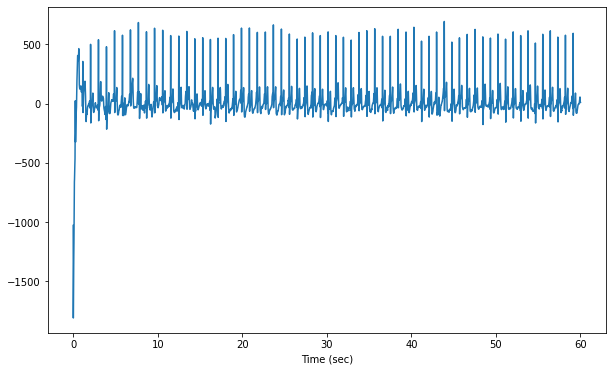

In [17]:
with np.load(f0) as f:
    v = f['ecg'] * 1000
plt.figure(figsize=(10, 6));
plt.plot(np.arange(len(v)) / fs, v)
plt.xlabel('Time (sec)');

Here, we can examine how the pre-processing steps change our signal and make it really easy for the decision algorithm to pick out the right peaks.

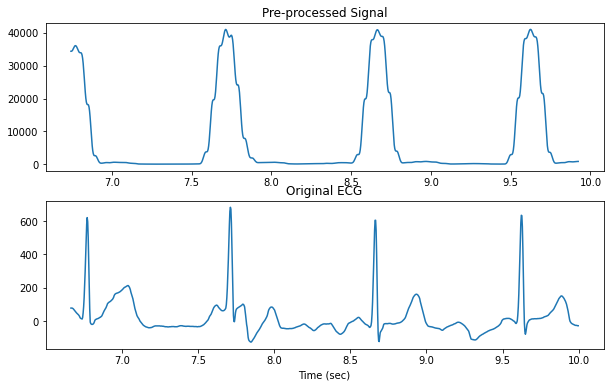

In [18]:
ts = np.arange(len(v)) / fs
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(ts[2001:3000], MovingSum(np.square(np.diff(BandpassFilter(v, 300)[2000:3000])), fs))
plt.title('Pre-processed Signal')
plt.subplot(2,1,2);
plt.plot(ts[2000:3000], v[2000:3000]);
plt.title('Original ECG')
plt.xlabel('Time (sec)');

After running Pan-Tompkins, we can see that all the peaks are detected.

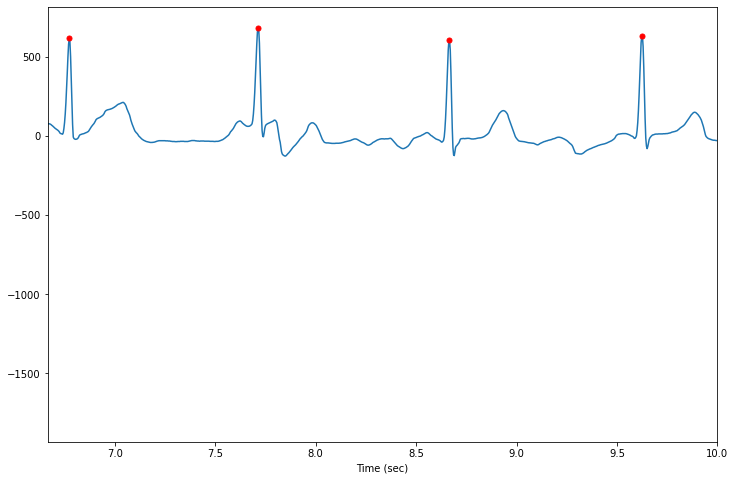

In [19]:
Plot(v, 300, (2000, 3000))